### Solve cavity flow governed by Navier-Stokes equation. using PINNs (Under simple setting)
Goal : using PINNs, predicts $(\psi, p)$ for the input $(x,y)$


Classical Navier-Stokes equation in 2D, Incompressible Navier-Stokes equations with constant viscosity (ignore external force)
\begin{gather}
\boldsymbol{u}_t + (\boldsymbol{u} \cdot \nabla)\boldsymbol{u} + \nabla \boldsymbol{p}/\rho - \nu \nabla^2 \boldsymbol{u}\\
\nabla \cdot \boldsymbol{u} = 0, \quad \text{where} \quad \boldsymbol{u}\equiv(u,v)
\end{gather}
If steady state $u_t = 0$
\begin{align}
u_x + v_y &= 0\\
u u_x + v u_y + p_x/\rho - \nu(u_{xx} + u_{yy}) &= 0\\
u v_x + v v_y + p_y/\rho - \nu(v_{xx} + v_{yy}) &= 0\\
\end{align}
boundary condition

$\{x,y\} \in \{0,1\}\times\{0,1\}$

$(u,v)=(1,0)$ for $y=0$ and $(u,v)=(0,0)$ for other boundaries.

For simplify, define stream function $ (u, v) = (\psi_y, -\psi_x)$

In [21]:
!pip install equinox jaxtyping # for colab invironment

Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [22]:
# YOUR CODE HERE (30pts)

import jax
from jax import numpy as jnp
import equinox as eqx
import optax
from jaxtyping import Array, Float, Int, PyTree

import numpy as np
import matplotlib.pyplot as plt

import tqdm

In [23]:
SEED = 5678
key = jax.random.PRNGKey(SEED)
rho = jnp.array(1.0)
nu = jnp.array(0.01)

xrange = [0, 1]
yrange = [0, 1]

In [24]:
def dataset_gen(n_slices_col=40, n_slice_bc=100):
    x = jnp.linspace(xrange[0], xrange[1], n_slices_col + 1)
    y = jnp.linspace(yrange[0], yrange[1], n_slices_col + 1)
    x_col, y_col = jnp.meshgrid(x, y, indexing='ij')

    x_bc_down = jnp.linspace(xrange[0], xrange[1], n_slice_bc + 1)
    y_bc_down = yrange[0] * jnp.ones((n_slice_bc + 1,))
    u_bc_down = jnp.ones_like(x_bc_down)
    v_bc_down = jnp.zeros_like(y_bc_down)

    x_bc_up = jnp.linspace(xrange[0], xrange[1], n_slice_bc + 1)
    y_bc_up = yrange[1] * jnp.ones((n_slice_bc + 1,))
    u_bc_up = jnp.zeros_like(x_bc_down)
    v_bc_up = jnp.zeros_like(y_bc_down)

    x_bc_left = xrange[0] * jnp.ones((n_slice_bc + 1,))
    y_bc_left = jnp.linspace(xrange[0], xrange[1], n_slice_bc + 1)
    u_bc_left = jnp.zeros_like(x_bc_down)
    v_bc_left = jnp.zeros_like(y_bc_down)

    x_bc_right = xrange[1] * jnp.ones((n_slice_bc + 1,))
    y_bc_right = jnp.linspace(xrange[0], xrange[1], n_slice_bc + 1)
    u_bc_right = jnp.zeros_like(x_bc_down)
    v_bc_right = jnp.zeros_like(y_bc_down)

    x_bc = jnp.concatenate([x_bc_down, x_bc_up, x_bc_left, x_bc_right])
    y_bc = jnp.concatenate([y_bc_down, y_bc_up, y_bc_left, y_bc_right])
    u_bc = jnp.concatenate([u_bc_down, u_bc_up, u_bc_left, u_bc_right])
    v_bc = jnp.concatenate([v_bc_down, v_bc_up, v_bc_left, v_bc_right])

    x_col = x_col.flatten()
    y_col = y_col.flatten()

    return x_col, y_col, x_bc, y_bc, u_bc, v_bc

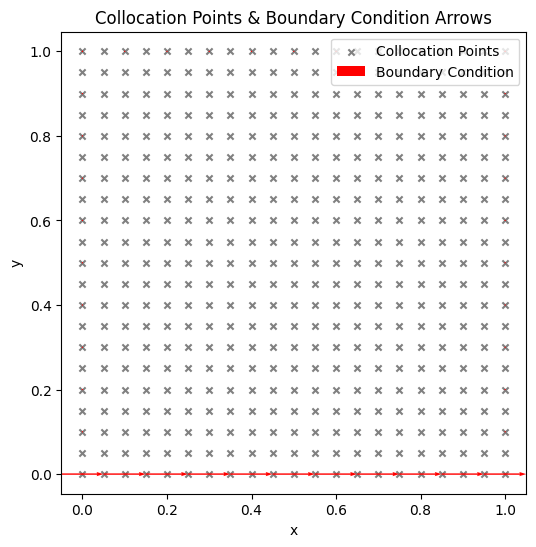

In [ ]:
x_col, y_col, x_bc, y_bc, u_bc, v_bc = dataset_gen(n_slices_col=20, n_slice_bc=10)

plt.figure(figsize=(6,6))
plt.scatter(x_col, y_col,
            marker='x', s=20, color='gray',
            label='Collocation Points')

plt.quiver(
    x_bc, y_bc,
    u_bc, v_bc,
    angles='xy', scale_units='xy', scale=12,
    width=0.003, headwidth=3, headlength=5,
    pivot='mid',
    color='red', label='Boundary Condition'
)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Collocation Points & Boundary Condition Arrows')
plt.axis('equal')
plt.legend()
plt.show()


In [26]:
# YOUR CODE HERE (30pts)

class PINN(eqx.Module):
    net: eqx.nn.MLP

    def __init__(self, key):

        self.net = eqx.nn.MLP(
            in_size=2,
            out_size=2,
            width_size=64,
            depth=5,
            activation=jax.nn.tanh,
            key=key
        )

    def __call__(self, x, y):
        xy = jnp.stack((x, y), axis=-1)
        out = self.net(xy)
        psi = out[..., 0]
        p   = out[..., 1]
        return psi, p


\begin{gather}
    u = \psi_y,\quad v = -\psi_x \\
    u_x = \psi_{yx},\quad u_y = \psi_{yy},\quad v_x = -\psi_{xx},\quad v_y = -\psi_{xy} \\
    u_x = \psi_{yxx},\quad u_y = \psi_{yyy},\quad v_x = -\psi_{xxx},\quad v_y = -\psi_{xyy} \\
\end{gather}

prediction $u$ and $v$:
\begin{gather}
    u^{(\text{model})} = \psi^{(\text{model})}_y(x, y),\quad v^{(\text{model})} = -\psi^{(\text{model})}_x(x, y)
\end{gather}

Residual for boundary condition:
\begin{equation}
    L_\text{BC}(x, y) = \left(u^{(\text{model})} - u^{(\text{BC})}\right)^2 + \left(v^{(\text{model})} - v^{(\text{BC})}\right)^2
\end{equation}

Residual for differential equation:
\begin{align}
    L_\text{PDE}(x, y)
    &= \left(u^{(\text{model})} u^{(\text{model})}_x + v^{(\text{model})} u^{(\text{model})}_y + p^{(\text{model})}_x/\rho - \nu(u^{(\text{model})}_{xx} + u^{(\text{model})}_{yy})\right)^2\\
    &+ \left(u^{(\text{model})} v^{(\text{model})}_x + v^{(\text{model})} v^{(\text{model})}_y + p^{(\text{model})}_y/\rho - \nu(v^{(\text{model})}_{xx} + v^{(\text{model})}_{yy})\right)^2
\end{align}

In [27]:
def residual_bc(model, x, y, u_bc, v_bc):
    psi_fn = lambda x, y: model(x, y)[0]
    p_fn   = lambda x, y: model(x, y)[1]

    psi_x  = jax.grad(psi_fn, 0)
    psi_y  = jax.grad(psi_fn, 1)

    u_pred = psi_y(x, y)
    v_pred = -psi_x(x, y)

    res_bc = (u_pred - u_bc) ** 2 + (v_pred - v_bc) ** 2
    return res_bc

def residual_pde(model, x, y):
    # zeroth
    psi_fn = lambda x, y: model(x, y)[0]
    p_fn   = lambda x, y: model(x, y)[1]

    # first
    psi_x  = jax.grad(psi_fn, 0)
    psi_y  = jax.grad(psi_fn, 1)
    p_x    = jax.grad(p_fn,   0)
    p_y    = jax.grad(p_fn,   1)

    # second
    psi_xx = jax.grad(psi_x, 0)
    psi_xy = jax.grad(psi_x, 1)
    psi_yy = jax.grad(psi_y, 1)

    # third
    psi_xxx = jax.grad(psi_xx, 0)
    psi_xxy = jax.grad(psi_xx, 1)
    psi_yyy = jax.grad(psi_yy, 1)
    psi_xyy = jax.grad(psi_xy, 1)

    u = psi_y(x, y)
    v = -psi_x(x, y)

    u_x = psi_xy(x, y)
    u_y = psi_yy(x, y)
    v_x = -psi_xx(x, y)
    v_y = -psi_xy(x, y)

    u_xx = psi_xxy(x, y)
    u_yy = psi_yyy(x, y)
    v_xx = -psi_xxx(x, y)
    v_yy = -psi_xyy(x, y)

    res_pde = (u * u_x + v * u_y + p_x(x, y) / rho - nu * (u_xx + u_yy)) ** 2 \
            + (u * v_x + v * v_y + p_y(x, y) / rho - nu * (v_xx + v_yy)) ** 2
    return res_pde

def loss_fn(model, dataset):
    x_col, y_col, x_bc, y_bc, u_bc, v_bc = dataset
    res_bc  = jax.vmap(residual_bc,  (None, 0, 0, 0, 0), 0)(model, x_bc, y_bc, u_bc, v_bc)
    res_pde = jax.vmap(residual_pde, (None, 0, 0),       0)(model, x_col, y_col)

    p_pred = jax.vmap(lambda x, y: model(x, y)[1], (0, 0), 0)(x_col, y_col)
    psi_pred = jax.vmap(lambda x, y: model(x, y)[0], (0, 0), 0)(x_col, y_col)
    zero_mean_loss = jnp.mean(p_pred) ** 2 + jnp.mean(psi_pred) ** 2

    return jnp.mean(res_bc) + jnp.mean(res_pde) + 0.1 * zero_mean_loss

In [28]:
# YOUR CODE HERE (30pts)

def train(
    model: PINN,
    dataset: tuple,
    optim: optax.GradientTransformation,
    steps: int,
):
    opt_state = optim.init(eqx.filter(model, eqx.is_array))

    losses = np.zeros(steps)
    gradnorms = np.zeros(steps)

    @eqx.filter_jit
    def make_step(
        model: PINN,
        opt_state: PyTree,
        dataset: tuple
    ):
        loss_value, grads = eqx.filter_value_and_grad(loss_fn)(model, dataset)
        updates, opt_state = optim.update(
            grads, opt_state, eqx.filter(model, eqx.is_array)
        )
        model = eqx.apply_updates(model, updates)
        grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        return model, opt_state, loss_value, grad_norm

    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        model, opt_state, loss_value, grad_norm = make_step(model, opt_state, dataset)
        losses[step] = float(loss_value)
        gradnorms[step] = float(grad_norm)
        pbar.set_postfix(loss=float(loss_value), gradnorm=float(grad_norm))

    return model, losses, gradnorms

def plot_metrics(losses, gradnorms):

    fig, ax1 = plt.subplots()

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss', color='tab:blue')
    ax1.set_yscale('log')
    ax1.plot(losses, color='tab:blue', label='Loss')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Grad Norm', color='tab:red')
    ax2.set_yscale('log')
    ax2.plot(gradnorms, color='tab:red', alpha=0.5, label='Grad Norm')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title('Training Metrics')
    plt.show()

In [29]:
key, subkey = jax.random.split(key, 2)
model = PINN(subkey)

dataset = dataset_gen(n_slices_col=64, n_slice_bc=512)

# Example loss
loss_val, grads = eqx.filter_value_and_grad(loss_fn)(model, dataset)
print("loss:", loss_val)

# Example inference
output = model(0.5, 0.5)
print(output)

loss: 0.24350815
(Array(0.0855966, dtype=float32), Array(-0.07707787, dtype=float32))


In [30]:
# hyperparameters
n_epochs = 50000
schedule = optax.piecewise_constant_schedule(
    init_value=1e-3,
    boundaries_and_scales={10000: 0.1}
)
optim = optax.adamw(schedule)

model, losses, gradnorms = train(model, dataset, optim, n_epochs)

training:  34%|███▍      | 17053/50000 [1:03:57<2:03:33,  4.44step/s, gradnorm=0.206, loss=0.00288]    


KeyboardInterrupt: 

In [ ]:
import pickle

def save_model(model: PINN, path: str):
    with open(path, "wb") as f:
        eqx.tree_serialise_leaves(f, model)

def load_model(path: str, key) -> PINN:
    model_template = PINN(key)
    with open(path, "rb") as f:
        return eqx.tree_deserialise_leaves(f, model_template)

save_model(model, "pinn_model.pkl")

In [ ]:
key, subkey = jax.random.split(key)
model = load_model("pinn_model.pkl", subkey)

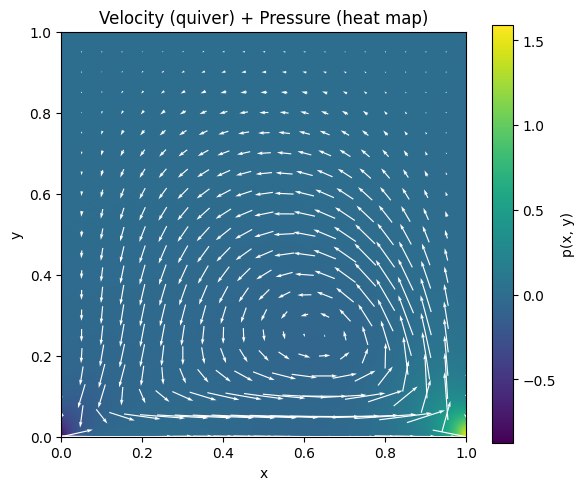

In [ ]:
# VISUALIZATION (10pts)

psi_fn = lambda x, y: model(x, y)[0]
p_fn   = lambda x, y: model(x, y)[1]

psi_x  = jax.grad(psi_fn, 0)
psi_y  = jax.grad(psi_fn, 1)

n = 1001
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X, Y = np.meshgrid(x, y, indexing="xy")
Xf = X.ravel()       # (n*n,)`  `
Yf = Y.ravel()

U = jax.vmap(psi_y)(Xf, Yf).reshape(n, n)
V = -jax.vmap(psi_x)(Xf, Yf).reshape(n, n)
P = jax.vmap(p_fn)(Xf, Yf).reshape(n, n)

fig, ax = plt.subplots(figsize=(6, 5))

# pressure heat map
im = ax.imshow(
    P,
    origin="lower",
    extent=[0, 1, 0, 1],
    cmap="viridis",
    aspect="equal"
)
cbar = fig.colorbar(im, ax=ax, label="p(x, y)")

# velocity quiver
step = 50
ax.quiver(
    X[::step, ::step],
    Y[::step, ::step],
    U[::step, ::step],
    V[::step, ::step],
    color="white",
    scale_units="xy",
    angles="xy",
    pivot='mid',
    scale=4
)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Velocity (quiver) + Pressure (heat map)")


plt.tight_layout()
plt.show()

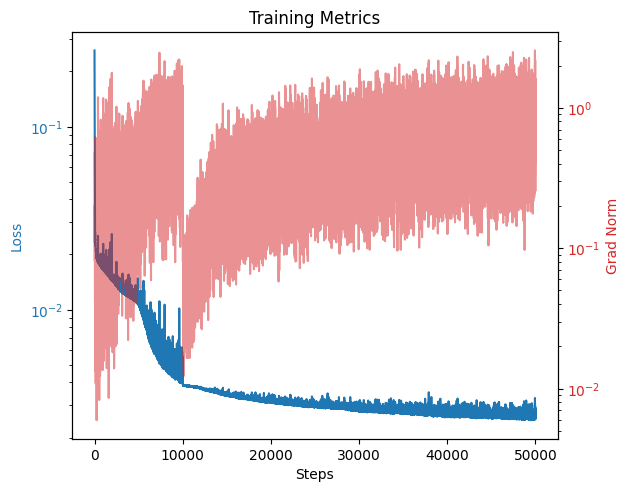

In [ ]:
plot_metrics(losses, gradnorms)

In [ ]:
x_col, y_col, x_bc, y_bc, u_bc, v_bc = dataset
res_bc  = jax.vmap(residual_bc,  (None, 0, 0, 0, 0), 0)(model, x_bc, y_bc, u_bc, v_bc)
res_pde = jax.vmap(residual_pde, (None, 0, 0),       0)(model, x_col, y_col)

p_pred = jax.vmap(lambda x, y: model(x, y)[1], (0, 0), 0)(x_col, y_col)

In [ ]:
jnp.mean(p_pred)

Array(-0.00087999, dtype=float32)

In [ ]:
jnp.mean(res_bc)

Array(0.0022885, dtype=float32)

In [ ]:
jnp.mean(res_pde)

Array(0.00035572, dtype=float32)